In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from datetime import datetime
import torch
import json
import mbuild as mb
import gmso
from gmso.external.convert_networkx import to_networkx
import networkx as nx
from urllib.request import urlopen
from urllib.parse import quote
import torch.nn.functional as F
import torch
from torch import nn
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear
from sklearn.metrics import mean_squared_error
from typing import List, Optional, Union
from collections.abc import Mapping, Sequence
from typing import List, Optional, Union

import torch.utils.data
from torch.utils.data.dataloader import default_collate

from torch_geometric.data import Batch, Dataset
from torch_geometric.data.data import BaseData


# import sys
# sys.path.insert(1, 'egnn/models/egnn_clean')
# sys.path.insert(1, 'egnn')
# import qm9
# from qm9 import dataset
# from easydict import EasyDict as edict
# from qm9 import utils as qm9_utils
# from qm9.models import EGNN
import torch
from torch import nn, optim

In [ ]:
device = torch.device("cpu")
dtype = torch.float32
df = pd.read_excel('./cloud_point.xlsx')
df = df.drop_duplicates().dropna()
dat = Cloud_Point_Dataset(root='.',dataframe=df)

batch_size = 16
loader = DataLoader(dat, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)

model = MEGNN(n_graphs=2, in_node_nf=7, in_edge_nf=0, hidden_nf=64, device=device, n_layers=7, coords_weight=1.0,
             attention=True, node_attr=1, n_enviro=4)
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)

In [3]:
COF_data_path = '/Users/kieran/iMoDELS-supplements/data/raw-data/everything.csv'
COF_data = pd.read_csv(COF_data_path, index_col=0)
COF_data = COF_data[['terminal_group_1','terminal_group_2','terminal_group_3', 'backbone', 'frac-1','frac-2','COF','intercept']]

molecules = glob.glob('/Users/kieran/terminal_groups_mixed/src/util/molecules/*.pdb')
molecules = list(set(molecules))
names2graph = {}
mol_smiles = {}
name2n_nodes = {}
name2xyz = {}
name2e_index = {}
name2mol = {}
name2x = {}

missing_mols = ['difluoromethyl', 'phenol', 'toluene']
def replace_name_graph(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return names2graph[chem_name]

def n_nodes_tuple(t1, t2):
    if t1 in missing_mols or t2 in missing_mols:
        return
    else:
        return (name2n_nodes[t1], name2n_nodes[t2])
def replace_n_nodes_tuple(row):
    return n_nodes_tuple(row['terminal_group_1'], row['terminal_group_2'])

def get_positions(t1,t2):
    if t1 in missing_mols or t2 in missing_mols:
        return
    else:
        return (name2xyz[t1], name2xyz[t2])
def replace_positions(row):
    return get_positions(row['terminal_group_1'], row['terminal_group_2'])

def replace_e_index(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return name2e_index[chem_name]
def replace_node_att(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        x = torch.empty((len(elements),name2n_nodes[chem_name]), dtype=torch.int32)
        for i, p in enumerate(name2mol[chem_name].particles()):
            x[i] = element2vec[p]
        return x

def CIRconvert(ids):
    url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
    ans = urlopen(url).read().decode('utf8')
    return ans

for ids in set(COF_data['terminal_group_1']):
    try:
        mol_smiles[ids] = CIRconvert(ids)
    except:
        pass
mol_smiles['nitrophenyl'] = 'CC1=CC=C(C=C1)[N+]([O-])=O'
mol_smiles['isopropyl'] = 'CC(C)O'
mol_smiles['perfluoromethyl'] = 'CC(F)(F)F'
mol_smiles['fluorophenyl'] = 'CC1=CC=C(F)C=C1'
mol_smiles['carboxyl'] = '*C(=O)O'
mol_smiles['amino'] = 'CN'


names = ''.join(smiles.upper() for smiles in mol_smiles.values())
elements = [n for n in set(names) if n.isalpha()]


vecs = F.one_hot(torch.arange(0, 5), num_classes=5)
element2vec = {e:v for e, v in zip(elements, vecs)}
vec2element = {v:e for e, v in zip(elements, vecs)}

for m in molecules:
    mol_name = m.split('/')[-1].split('.')[0]
    if 'ch3' in mol_name:
        mol_name = mol_name.split('-')[0]
    mol = mb.load(m)
    G = to_networkx(mol.to_gmso())
    adj = nx.adjacency_matrix(G)
    names2graph[mol_name] = adj
    name2n_nodes[mol_name] = len(list(G.nodes))
    name2xyz[mol_name] = mol.xyz
    name2mol[mol_name] = mol
    e_index = torch.empty((2,mol.n_bonds), dtype=torch.int64)
    parts = {p:i for i, p in enumerate(mol.particles())}
    for i, b in enumerate(mol.bonds()):
        e_index[0,i] = parts[b[0]]
        e_index[1,i] = parts[b[1]]
    name2e_index[mol_name] = e_index
    x = torch.empty((mol.n_particles,len(elements)), dtype=torch.float32)
    for i, p in enumerate(mol.particles()):
        x[i] = element2vec[p.element.symbol]
    name2x[mol_name] = x

COF_data['n_nodes'] = COF_data.apply(replace_n_nodes_tuple,axis=1)
COF_data = COF_data.dropna()
COF_data = COF_data[(COF_data['frac-1']==.5)]
COF_data.reset_index()

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/subtopology.py:70: UserWarning: Setting a parent is potentially dangerous. Consider using Topology.add_subtopology instead
  warnings.warn(
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom C, label: None id: 140616920424208>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom O, label: None id: 140616920424400>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom O, label: None id: 140616912531712>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs

,index,terminal_group_1,terminal_group_2,terminal_group_3,backbone,frac-1,frac-2,COF,intercept,n_nodes
0,0,acetyl,acetyl,acetyl,alkylsilane,0.5,0.5,0.140174,1.292272,"(10, 10)"
1,1,acetyl,acetyl,carboxyl,alkylsilane,0.5,0.5,0.144711,3.382495,"(10, 10)"
2,2,acetyl,acetyl,fluorophenyl,alkylsilane,0.5,0.5,0.120846,1.448256,"(10, 10)"
3,3,acetyl,acetyl,hydroxyl,alkylsilane,0.5,0.5,0.149766,2.171407,"(10, 10)"
4,4,acetyl,acetyl,isopropyl,alkylsilane,0.5,0.5,0.131951,0.748749,"(10, 10)"
...,...,...,...,...,...,...,...,...,...,...
2375,3306,phenyl,pyrrole,phenol,alkylsilane,0.5,0.5,0.125767,2.664638,"(15, 13)"
2376,3307,phenyl,pyrrole,phenyl,alkylsilane,0.5,0.5,0.127045,1.369260,"(15, 13)"
2377,3308,phenyl,pyrrole,pyrrole,alkylsilane,0.5,0.5,0.136313,1.192587,"(15, 13)"
2378,3309,phenyl,pyrrole,toluene,alkylsilane,0.5,0.5,0.142473,1.098868,"(15, 13)"


In [5]:
from megnn import * 
from loader import * 
from utils import * 

In [7]:
import torch_geometric as tg


dat = COF_Dataset(root='.')

dat.shuffle()
train_dataset = dat[:int(len(dat)*.8)]
test_dataset = dat[int(len(dat)*.8):]
train_loader = DataLoader(train_dataset, batch_size=2, follow_batch=['x_s', 'x_t', 'positions_s','positions_t'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, follow_batch=['x_s', 'x_t'], shuffle=False)
device = torch.device("cpu")

edges_dic = {}
def get_adj_matrix(n_nodes, batch_size, device):
    if n_nodes in edges_dic:
        edges_dic_b = edges_dic[n_nodes]
        if batch_size in edges_dic_b:
            return edges_dic_b[batch_size]
        else:
            # get edges for a single sample
            rows, cols = [], []
            for batch_idx in range(batch_size):
                for i in range(n_nodes):
                    for j in range(n_nodes):
                        rows.append(i + batch_idx*n_nodes)
                        cols.append(j + batch_idx*n_nodes)

    else:
        edges_dic[n_nodes] = {}
        return get_adj_matrix(n_nodes, batch_size, device)

    edges = [torch.LongTensor(rows).to(device), torch.LongTensor(cols).to(device)]
    return edges

def preprocess_input(one_hot, charges, charge_power, charge_scale, device):
    charge_tensor = (charges.unsqueeze(-1) / charge_scale).pow(
        torch.arange(charge_power + 1., device=device, dtype=torch.float32))
    charge_tensor = charge_tensor.view(charges.shape + (1, charge_power + 1))
    atom_scalars = (one_hot.unsqueeze(-1) * charge_tensor).view(charges.shape[:2] + (-1,))
    return atom_scalars

for i, data in enumerate(zip(dataloaders['train'], train_loader)):
    batch_size, n_nodes, _ = data[0]['positions'].size()
    row, col = get_adj_matrix(n_nodes, batch_size, device)
    # row, col = get_adj_matrix(17, 8, device)
    
    
    dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data[1].positions_s, data[1].positions_s_batch)
    dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data[1].positions_t, data[1].positions_t_batch)
    batch_size_s, n_nodes_s, _ = dense_positions_s.size()
    batch_size_t, n_nodes_t, _ = dense_positions_t.size()
    atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1)
    atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1)
    edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
    #mask diagonal
    diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_s *= diag_mask
    edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1)
    edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
    edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
    #mask diagonal
    diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_t *= diag_mask
    edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t, n_nodes_t, 1)

    atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1)
    atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1)

    one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data[1].x_s, data[1].x_s_batch)
    one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data[1].x_t, data[1].x_t_batch)
    one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1)
    one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1)
    edges_s = qm9_utils.get_adj_matrix(n_nodes_s, batch_size_s, device)
    edges_t = qm9_utils.get_adj_matrix(n_nodes_t, batch_size_t, device)

    
    print('pos size', atom_positions_s.size())
    print('atommask size', atom_mask_s.size())
    print('edgemask size', edge_mask_s.size())
    print('one_hot size', one_hot_s.size())
    print('row size', type(edges_s[0]))

    break

NameError: name 'dataloaders' is not defined

In [10]:

import torch
from torch import nn, optim
import argparse

import utils
import json
from easydict import EasyDict as edict
import torch_geometric as tg

n_epochs  = 30

device = torch.device("cpu")
dtype = torch.float32

dat = COF_Dataset(root='.')

batch_size = 32

dat.shuffle()
train_dataset = dat[:int(len(dat)*.8)]
test_dataset = dat[int(len(dat)*.8):]
train_loader = DataLoader(train_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=False)

def compute_cof_mean_mad(data):
    values = torch.Tensor(data['COF'])
    mean = torch.mean(values)
    ma = torch.abs(values - mean)
    mad = torch.mean(ma)
    return mean, mad

prop_mean, prop_mad = compute_cof_mean_mad(COF_data)

model = PairEGNN(in_node_nf=5, in_edge_nf=0, hidden_nf=128, device=device, n_layers=8, coords_weight=1.,
             attention=False, node_attr=1)

print(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-16)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
criterion = nn.L1Loss()


def train(epoch, loader):
    epoch_loss = 0
    lr_scheduler.step()
    model.train()

    for i, data in enumerate(loader):
        dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
        dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
        batch_size_s, n_nodes_s, _ = dense_positions_s.size()
        batch_size_t, n_nodes_t, _ = dense_positions_t.size()
        atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
        atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)

        edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_s *= diag_mask
        edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
        edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_t *= diag_mask
        edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)

        atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
        atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)

        one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
        one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
        one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
        one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
        edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
        edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)
        label = data.y.to(device, dtype)

        pred = model(h0_s=one_hot_s, h0_t=one_hot_t, edges_s=edges_s, edges_t=edges_t, edge_attr=None, node_mask_s=atom_mask_s, 
                    edge_mask_s=edge_mask_s, n_nodes_s=n_nodes_s, node_mask_t=atom_mask_t, edge_mask_t=edge_mask_t, 
                    n_nodes_t=n_nodes_t, x_s=atom_positions_s, x_t=atom_positions_t)


        loss = criterion(pred, label)  # Compute the loss.
        epoch_loss += loss.item() * batch_size_s
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        if i % 10 == 0:
            print("Epoch %d \t Iteration %d \t loss %.4f" % (epoch, i, loss.item()))
    return epoch_loss
    
def test(loader):
    model.eval()

    epoch_loss = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
        dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
        batch_size_s, n_nodes_s, _ = dense_positions_s.size()
        batch_size_t, n_nodes_t, _ = dense_positions_t.size()
        atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
        atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)

        edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_s *= diag_mask
        edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
        edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_t *= diag_mask
        edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)

        atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
        atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)

        one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
        one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
        one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
        one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
        edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
        edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)
        label = data.y.to(device, dtype)
        pred = model(h0_s=one_hot_s, h0_t=one_hot_t, edges_s=edges_s, edges_t=edges_t, edge_attr=None, node_mask_s=atom_mask_s, 
                    edge_mask_s=edge_mask_s, n_nodes_s=n_nodes_s, node_mask_t=atom_mask_t, edge_mask_t=edge_mask_t, 
                    n_nodes_t=n_nodes_t, x_s=atom_positions_s, x_t=atom_positions_t)

        # epoch_loss += criterion(pred, (label - prop_mean) / prop_mad).item()*batch_size
        epoch_loss += criterion(pred, label).item()*batch_size_s

    return epoch_loss

res = {'epochs': [], 'train_loss': [],'test_loss': [], 'best_val': 1e10, 'best_test': 1e10, 'best_epoch': 0}

for epoch in range(0, n_epochs):
    train_loss = train(epoch, train_loader)
    res['train_loss'].append(train_loss)
    if epoch % 4 == 0:
        test_loss = test(test_loader)
        res['epochs'].append(epoch)
        res['test_loss'].append(test_loss)

        if test_loss < res['best_val']:
            res['best_val'] = test_loss
            res['best_test'] = test_loss
            res['best_epoch'] = epoch
        print("test loss: %.4f \t epoch %d" % (test_loss, epoch))
        print("Best: val loss: %.4f \t test loss: %.4f \t epoch %d" % (res['best_val'], res['best_test'], res['best_epoch']))


    # json_object = json.dumps(res, indent=4)
    # with open(args.outf + "/" + args.exp_name + "/losess.json", "w") as outfile:
    #     outfile.write(json_object)

PairEGNN(
  (embedding_s): Linear(in_features=5, out_features=128, bias=True)
  (embedding_t): Linear(in_features=5, out_features=128, bias=True)
  (gcl_s_0): E_GCL_mask(
    (edge_mlp): Sequential(
      (0): Linear(in_features=257, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): SiLU()
    )
    (node_mlp): Sequential(
      (0): Linear(in_features=261, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (act_fn): SiLU()
  )
  (gcl_t_0): E_GCL_mask(
    (edge_mlp): Sequential(
      (0): Linear(in_features=257, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): SiLU()
    )
    (node_mlp): Sequential(
      (0): Linear(in_features=261, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (act_fn): SiLU()
  

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x7 and 5x128)

In [28]:
plt.figure(figsize=(12,6))
plt.plot(list(range(len(res['train_loss']))), res['train_loss'],label='training')
plt.plot(res['epochs'], res['test_loss'],label='testing')
plt.ylabel('L1 Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.legend()
plt.savefig('results.png')

In [ ]:
n_epochs = 100
model = PairGNN(hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    epoch_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(x_s=data.x_s.float(), edge_index_s=data.edge_index_s, x_t=data.x_t.float(),
                    edge_index_t=data.edge_index_t, x_s_batch = data.x_s_batch, x_t_batch = data.x_t_batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        epoch_loss += loss
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return epoch_loss

def test(loader):
    model.eval()

    squared_error = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(x_s=data.x_s.float(), edge_index_s=data.edge_index_s, x_t=data.x_t.float(),
                    edge_index_t=data.edge_index_t, x_s_batch = data.x_s_batch, x_t_batch = data.x_t_batch)
        res = data.y - out
        
        squared_error.append(torch.pow(res, 2).sum())

    return sum(squared_error) / len(squared_error)

training_loss = []
testing_loss = []

for epoch in range(1, n_epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    training_loss.append(train_acc.detach().numpy())
    testing_loss.append(test_acc.detach().numpy())
    print(f'Epoch: {epoch:03d}, Train MSE: {train_acc:.4f}, Test MSE: {test_acc:.4f}')

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Train MSE: 1.9399, Test MSE: 4.5168
Epoch: 002, Train MSE: 1.2434, Test MSE: 4.8490
Epoch: 003, Train MSE: 1.1539, Test MSE: 4.7538
Epoch: 004, Train MSE: 1.5170, Test MSE: 5.2531
Epoch: 005, Train MSE: 1.5871, Test MSE: 5.3106
Epoch: 006, Train MSE: 1.0313, Test MSE: 3.7780
Epoch: 007, Train MSE: 0.9936, Test MSE: 4.0974
Epoch: 008, Train MSE: 1.4585, Test MSE: 4.6294
Epoch: 009, Train MSE: 1.1938, Test MSE: 3.9663
Epoch: 010, Train MSE: 1.0246, Test MSE: 3.5477
Epoch: 011, Train MSE: 0.8579, Test MSE: 2.9595
Epoch: 012, Train MSE: 0.8693, Test MSE: 2.6871
Epoch: 013, Train MSE: 0.9094, Test MSE: 1.9636
Epoch: 014, Train MSE: 0.8201, Test MSE: 1.9024
Epoch: 015, Train MSE: 0.7964, Test MSE: 1.6647
Epoch: 016, Train MSE: 1.0586, Test MSE: 2.0867
Epoch: 017, Train MSE: 0.7911, Test MSE: 1.5282
Epoch: 018, Train MSE: 1.0394, Test MSE: 1.8413
Epoch: 019, Train MSE: 0.8676, Test MSE: 1.5352
Epoch: 020, Train MSE: 1.1689, Test MSE: 1.8412
Epoch: 021, Train MSE: 1.3266, Test MSE:

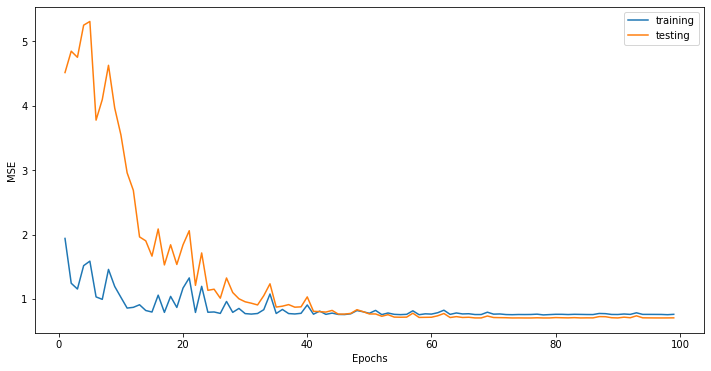

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1, n_epochs), training_loss,label='training')
plt.plot(range(1, n_epochs), testing_loss,label='testing')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()